# Der mehrdimensionale Kalman-Filter, Teil 1 Grundlagen
25.7.2019, S. Mack

In [1]:
# display plots inside this notebook
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np

Die wichtigsten Erkenntnisse des voran gegangenen Jupyter-Notebooks zu den mehrdimensionalen Gaußverteilungen waren:
* Aus der skalaren Zufallsvariable und dem skalaren Erwartungswert werden beim Übergang von der eindimensionalen auf die mehrdimensionale Gaußverteilung Vektoren. Der Vektor $\boldsymbol\mu$ des Erwartungswerts besitzt für jede Zufallsvariable $i$ im entsprechenden Element den dazugehörigen Erwartungswert $\mu_i$.
* Aus der skalaren Standardabweichung wir im n-dimensionalen Fall eine $n \times n$-Matrix, die sogenannte Kovarianzmatrix $\Sigma$. In deren Diagonalelementen $\Sigma_{ii}$ stecken die Varianzen der einzelnen Zufallsvariablen $i$. Außerhalb der Diagonalen befinden sich in den Elementen $\Sigma_{ij}$ die Kovarianzen, also das Korrelationsausmaß zwischen den beiden Zufallsvariablen $i$ und $j$.
* Beim Kalman-Filter sind die Zustandsgrößen die Zufallsvariablen. Auch sie werden zu Vektoren.
* Der Korrekturschritt ist wie im eindimensionalen Fall eine Multiplikation der beiden jetzt mehrdimensionalen Gaußverteilungen von Vorhersage und Messwert. Da Mathematik dazu ändert sich nicht wesentlich.
* Die Korrelation zweier Zustandsgrößen führt dazu, dass dieser Korrekturschritt einen erheblich genaueren Schätzwert liefert als wären diese unkorreliert.
* Selbst wenn eine Zustandsgröße nicht gemessen wird, kann ihr Wert aufgrund der Korrelation genau geschätzt werden. Die Funktion des Kalman-Filters ist in diesem Fall primär gar nicht das Filtern der Messdaten sondern das Schätzen eines Paramters des physikalischen Modells, welcher oft gar nicht mit Sensoren erfasst werden kann.  

Im mehrdimensionalen Kalman-Filter **spielt die Korrelation zweier Zustandsgrößen** die zentrale Rolle.  

Dieses Jupyter-Notebook behaldelt nur auf eine Unterklasse von mehrdimensionalen Kalman-Filtern: Filter mit einem physikalischen Modell, welches auf den newtonschen Bewegungsgleichungen beruht. Hierfür wird aber die allgemeine Form eines Kalman-Filters verwendet, so dass sich an den hier vorgestellen Algorithmen und an der Mathematik nichts wesentlich ändert, falls ein Kalman-Filter z.B. für die Ladezustand einer Batterie verwendet werden soll.  
In diesem Sinne werden im nächsten Kapitel zuerst einmal die newtonschen Bewegungsgleichungen wiederholt:

 ## Die newtonschen Bewegungsgleichungen

Die einfachste newtonsche Bewegungsgleichung berechnet bei bekannter Geschwindigkeit $v$ die Position $x$ in Abhängigkeit von der verstrichenen Zeit $t$:

$$x = vt + x_0$$

Beispielsweise startet ein Fahrzeug an der Position $x_0 = 13$, besitzt eine konstante Geschwindigkeit $v = 10 m/s$ und fährt $t = 12 s$ lang. Am Ende dieser Zeit erreicht es somit die Position $ 133  = 10 \cdot 12 + 13$ .

In einer etwas komplexeren Bewegungsgleichung besitzt das Fahrzeug zusätzlich eine Beschleunigung $a$. Jetz ist nicht nur die Position $x$ sondern auch die (momentane) Geschwindigkeit $v$ von der verstrichenen Zeit $t$ abhängig:

$$x = \frac{1}{2}at^2 + v_0t + x_0$$

Beide Bewegungsgleichungen sind Lösungen des sogenannten zweiten newtonschen Gesetzes $F = m \cdot a$. Der Fall $a=0$ ist streng genommen das erste newtonsche Gesetz: "Wirkt auf einen Körper keine Kraft, so ist seine Geschwindigkeit zeitlich konstant". Somit gilt mit $v = const.$:

$$\begin{aligned} v &= \frac{dx}{dt}\\
dx &= v\, dt \\
\int_{x_0}^x\, dx &= \int_0^t v\, dt\\
x - x_0 &= vt - 0\\
x &= vt + x_0\end{aligned}$$

Die Ausgangsformel oben ist eine (triviale) Differentialgleichung.  
*Für die hier behandelte Unterklasse von Kalman-Filtern sind es genau solche Differentialgleichungen der Zustandsgrößen, welche die Grundlage für das physikalisches Modell bilden.* Hier sind es konkret die newtonschen Gesetze für einen Kalman-Filter, der die Bewegung des Roboterfahrzeugs tracken soll.

## Kalman-Filter: Von eindimensional auf mehrdimensional
Nachfolgend ist nochmals der grundlegende Algorithmus eines Kalman-Filters wie schon im Jupyter-Notebook des eindimensionalen Kalman-Filters grafisch dargestellt.  

<img src="grafikKalman_VorhersKorr.png" width="800">   

>Ein Kalman-Filter erstellt eine Vorhersage, macht eine Messung und berechnet daraus einen Korrekturwert (auch Schätzwert genannt), der zwischen dem Vorhersagewert und dem Messwert liegt.  

Dieser generische Kalman-Filter-Algorithmus für den mehrdimensionalen Fall lässt sich in neun Schritten beschreiben: 
  
**Initialisieung**

1. Ein physikalisches Modell erstellen und daraus eine mathematische Berechnungsformel für die Vorhersage ableiten.
2. Einen Startwert der Zustandsgrößen (Werte, Varianzen) willkürlich festlegen.
    
**Vorhersage**

1. Die Zustandswerte für den nächsten Zeitschrit mit Hilfe des Prozessmodells vorhersagen.
2. Die Unsicherheit des Prozessmodells in die Varianz des Vorhersagewerts einfließen lassen.
    
**Korrektur**

1. Messungen jeder Zustandsgröße durchführen und wenn möglich deren Varianzen bestimmen, falls diese nicht als  konstant angenommen werden.
2. Die Resuiduen jeweils von Messwert minus Vorhersagewert berechnen.
3. Die Gewichtungsfaktoren (Kalman Gain) über den jeweiligen Vergleich der Varianzen von Messwert und Vorhersagewert berechnen.
4. Mit den Gewichtungsfaktoren die Korrekturwerte jeweils zwischen Messwert und Vorhersagewert verorten.
5. Die Varianzen der Korrekturwerte jeweils über die Varianzen von Mess- und Vorhersagewerte berechnen.

Gegenüber dem entsprechenden Abschnitt im Jupyter-Notebook zum eindimensionalen Kalman-Filter hat sich hier bei einigen Begriffen nur der Numerus von Einzahl auf Mehrzahl geändert - der Algorithmus ist der selbe geblieben.

Im Jupyter-Notebook zum eindimensionalen Kalman-Filter wurde schon der Übergang von der allgemeinen statistischen Notation ($\mu$, $\sigma^2$ usw.) zur Kalman-Notation ($x$, $P$, $Q$, usw.) dargestellt. Die folgenden Tabellen bauen darauf auf und erhalten nun eine weitere Spalte für den mehrdimensionalen Kalman-Filter. Aus den Skalaren werden nun fett gedruckte Vektoren bzw. Matrizen:

<u>Vorhersage</u>

$\begin{array}{|l|l|l|}
\hline
\text{Notation} &  \text{Notation}& \text{Notation}\\
\text{eindim. Statistik} & \text{eindim. Kalman} & \text{mehrdim. Kalman}\\
\hline
\bar \mu = \mu + \mu_{f_x} & \bar x = \hat x + dx & \bar{\mathbf x} = \mathbf{F \hat x} + \mathbf{Bu}\\
\bar\sigma^2 = \sigma_x^2 + \sigma_{f_x}^2 & \bar P = P + Q & \bar{\mathbf P} = \mathbf{FPF}^\mathsf T + \mathbf Q \\
\hline
\end{array}$

Auch ohne Kenntnisse in linearer Algebra lassen sich aus den Gleichungen oben folgende Korrespondenzen zwischen der eindimensionalen und mehrdimensionalen Kalman-Notation ablesen:

$\mathbf {\hat x}$ und $\mathbf P$ sind der Erwartungswertvektor und die Kovarianzmatrix der Zustandsgröße. Sie entsprechen in der Gaußstatistik-Notation den Skalaren $\hat x$ und $\sigma^2$ im eindimensionalen Fall bzw. dem Vektor $\boldsymbol \mu$ sowie der Matrix $ \boldsymbol \Sigma$ im mehrdimensionalen Fall.

$\mathbf F$ ist ebenfalls eine Matrix und wird als *Übergangsmatrix* bezeichnet. In ihr steckt das physikalische Modell, ihre Multiplikation mit dem Zustandsvektor $\mathbf{\hat x}$ ergibt die Vorhersage $\mathbf{\bar x}$. 

$\mathbf Q$ ist die Kovarianzmatrix des Prozessrauschens. Sie entspricht im eindimensionalen Fall $\sigma^2_{f_x}$. In ihr stecken die Unsicherheiten des Modells. Meistens besitzt sie nur Diagonalelemente, die entsprechenden Prozess-Varianzen der einzelnen Zustandsgrößen darstellen.

$\mathbf B$ und $\mathbf u$ sind neu. Sie beschreiben den Einfluss einer äußeren deterministischen Störung oder Steuerung des Systems. Mann nennt sie *Stömatrix* bzw. *Steuermatrix* und *Störgröße* bzw. *Steuergröße*.

<u>Korrektur</u>

$\begin{array}{|l|l|l|}
\hline
\text{Notation} &  \text{Notation}& \text{Notation}\\
\text{eindim. Statistik} & \text{eindim. Kalman} & \text{mehrdim. Kalman}\\
\hline
& y = z - \bar x & \mathbf y = \mathbf z - \mathbf{H\bar x} \\
& K = \frac{\bar P}{\bar P+R}&
\mathbf K = \mathbf{\bar{P}H}^\mathsf T (\mathbf{H\bar{P}H}^\mathsf T + \mathbf R)^{-1} \\
\mu=\frac{\bar\sigma^2\, \mu_z + \sigma_z^2 \, \bar\mu} {\bar\sigma^2 + \sigma_z^2} & \hat x = \bar x + Ky & \mathbf{\hat x} = \mathbf {\bar x} + \mathbf{Ky} \\
\sigma^2 = \frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2} & P = (1-K)\bar P &
\mathbf P = (\mathbf I - \mathbf{KH})\mathbf{\bar{P}} \\
\hline
\end{array}$


$\mathbf H$ ist die Beobachtungsmatrix. Ihr Sinn und Zweck wird später behandelt. Sie hat etwas damit zu tun, dass eine Zustandsgröße $x_i$ oft nicht 1:1 dem entsprechenden Messwert $z_i$ entspricht. Vorerst wird aber angenommen, dass Messgröße und Zustandsgröße identisch sind, also $\mathbf H = \mathbf 1$ gilt. Dies ist z.B. bei der Abstandmessung des Beispiel-Roboterfahrzeugs der Fall. Somit kann $\mathbf H$ aus den Gleichungen oben entfernt werden. Dadurch wird die Ähnlichkeit zum eindimensionalen Fall leicht sichtbar:  

$\mathbf z$ und $\mathbf R$ sind der Messwertvektor und dessen Kovarianzmatrix (aka Messunsicherheiten). Diese entsprechen $z$ bzw. $\sigma_z^2$ für den eindimensionalen Fall.

$\mathbf y$ und $\mathbf K$ bezeichnen das Residuum und den Kalman-Gain - im mehrdimensionalen Fall in Form eines Vektors bzw. einer Matrix. 

Genau wie beim Übergang von der eindimensionalen zur mehrdimensionalen Gaußverteilung werden beim Kalman-Filter aus Skalare Vektoren bzw. Matrizen. Die einzelnen Schritte einer Vorhersage-Korrektur-Iteration sind jedoch gleich geblieben:  

-  Der Schätzwert und dessen Unsicherheit eines Zustands wird durch eine (mehrdimensionale) Gaußverteilung repräsentiert.
-  Der Messwert und dessen Unsicherheit wird durch eine (mehrdimensionale) Gaußverteilung repräsentiert.
-  Auch das Prozessmodell wird duch eine (mehrdimensionale) Gaußverteilung repräsentiert, da es ebefalls mit Unsicherheiten behaftet ist.
-  Über das Prozessmodell wird eine Vorhersage für den nächsten Zustandswert berechnet.
-  Der neue Schätzwert liegt je nach Verhältnis der Unsicherheiten zwischen dem Vorhersagewert und dem neuen Messwert.

Um einen Kalman-Filter auf die Beine zu stellen, muss man also die Übergangsmatrix $\mathbf F$ deren Kovarianzmatrix $\mathbf Q$ (Prozessrauschen), die Beobachtungsmatrix $\mathbf H$ und ggfs. die Störmatrix $\mathbf B$ bestimmen. Falls nicht vom Sensor geliefert benötigt man zusätzlich für den Messwert $\mathbf z $ die Kovarianzmatrix  $\mathbf R$ der Messunsicherheiten.   
Dann benötigt man noch einen Startwert für den ersten Schätzwert $\mathbf x_0$  und dessen Kovarianzmatrix $\mathbf P$. Die Eingangsgrößen des Kalmanfilters sind dann die Messwerte $\mathbf z $ sowie ggfs. die Störgrößen $\mathbf u$.

#### Bemerkung zur Notation:
In der Literatur wird meistens das Symbol $\mathbf x$ nicht nur für den Zustandsvektor sondern auch für den Schätzwert, also den Erwartungswert des Zustandsvektors verwendet. In diesen Jupyter-Notebooks wird jedoch zwischen $\mathbf x$ und $\mathbf {\hat x}$ unterschieden. Das Dach gibt an, dass es sich um einen Schätzwert, also dem Ergebnis des Korrekturschritts handelt.

## Beispiel Roboterfahrzeug

Nachfolgend soll ein zweidimensionaler Kalman-Filter entwickelt werden, der genau wie im Jupyter-Notebook des g-h-Filters bzw. des eindimensionalen Kalman-Filters ein Roboterfahrzeug tracken soll.
<img src="RoboFahrzeug15Grad.png" width="400">
Wie im schon bekannten Bild oben dargestellt, fährt das Roboterfahrzeug geradlinig schräg zu einer Wand. Gemessen wird der Abstand zur Wand.  
Ander als beim eindimensionalen Kalman-Filter soll nun auch die Änderung des Wandabstands getrackt und ausgegeben werden. Die Relativgeschwindigkeit zur Wand ist also die zweite Zustandsgröße in dem hier zu entwickelnden *mehrdimensionalen* Kalman-Filter.  
Anders als im eindimensionalen Fall soll nun das physikalische Modell nicht starr *nur für einen* vorgegebenen Winkel (= Relativgeschwindigkeit) zur Wand funktionieren.

# Konkret: Zweidimensionaler Kalman-Filter für das Roboterfahrzeug
Der zweidimensionale Kalman-Filter des folgenden Abschnitts soll am Beispiels des Roboterfahrzeugs entwickelt und im folgenden Jupyter-Notebook mithilfe einer Simulation getestet werden.  

Der Zustandsgrößenvektor $\mathbf x$ besteht nun aus den beiden Komponenten *Abstand zur Wand* $ d = x_0$ und *Relativgeschwindigkeit zur Wand* $\frac{d}{dt} d = x_1$.  
Der zu entwickelnde Kalman-Filter soll nun beide Zustandsgrößen tracken, d.h. er soll Schätzwerte für den Abstand und die Abstandsänderung ausgeben sowie deren Varianzen berechnen. Normalerweise gibt es zu jeder Zustandsgröße einen Messwert. Man spricht dann von einer ***beobachteten* Zustandsgröße**. Im Fall der Relativgeschwindigkeit zur Wand gibt es jedoch beim Beispiel des Roboterfahrzeugs keinen Sensor. Daher handelt es sich bei dieser Zustandsgröße um eine sogenannte ***verdeckte* Zustandsgröße**.  

**Der Kalman-Filter soll nun also nicht nur den Wandabstand sondern auch die Abstandsänderung schätzen.** Das klingt jetzt nicht besonders sexy, aber führt dazu, dass anders als im eindimensionalen Fall dieser neue Kalmanfilter nicht auf einen bestimmten Winkel zur Wand voreingestellt ist - also wesentlich besser funktioniert, wenn der wahre Winkel nicht bekannt ist, und daher das physikalische Modell diesen falsch annimmt.   
Die neue Kalman-Filter-Funktion, den Wert der verdeckten Zustandsgröße auszugeben, ist in diesem speziellen Fall nicht wirklich der Rede wert. Es gibt aber andere Kalman-Filter die schätzen verdeckte Zustandsgrößen, die gar keiner Messung zugänglich sind. Das beste Beispiel hierfür ist das ESP eines Autos, welches die Querbewegung als verdeckte Zustandsgröße schätzt.  

Nun wird zuerst der Vorhersageschritt und anschließend der Korrekturschritt des Kalmanfilters betrachtet. Es wird jeweils der Algorithmus, die mathematische und anschließend die Python-Implementierung behandelt.

## Der Vorhersageschritt und das physikalische Modell (Prozessmodell) beim zweidimensionalen Kalman-Filter

In den nun folgenden Abschnitten werden die einzelnen Paramter für den Vorhersageschritt entwickelt und diskutiert.

### Der Zustandsvektor
In diesem zweidimensionalen Fall besitzt der Zustandsvektor $\mathbf x$ zwei Elemente (Abstand und Abstandsänderung). Beträgt beispielsweise der Erwartungswert des Abstands 1,0 m und der Abstandsänderung 0,45 m pro Sekunde, dann gilt für den Zustandsvektor:

$$\boldsymbol \mu = \mathbf x = \begin{bmatrix}1,0\\0,45\end{bmatrix}$$

Von hier an wird nur noch die Kalman-Notation verwendet, der Erwartungswert des Zustandsvekors wird also mit $ \mathbf x $ statt mit $\boldsymbol \mu$ bezeichnet. Seine Elemente "$x_i$" bezeichnen also jeweils eine Zustandsgröße.  
"$x_i$" muss nicht unbedingt für einen Weg oder einen Abstand sehen, wie der Buchstabe "x" vielleicht andeuten würde. Sondern  "$x_0$" könnte eine Batteriespannung sein und "$x_2$" beispielsweise ein Batterieladezustand.   

Für das Roboterfahrzeug ist der Zustandsvektor $\mathbf x$ gleich
$$\mathbf x =\begin{bmatrix}d \\ \dot d\end{bmatrix}$$
Üblicherweise verwendet man in Texten die Schreibweise $\mathbf x =\begin{bmatrix}d & \dot d\end{bmatrix}^\mathsf T$, also die entsprechende 1x2 Matrix tranponiert, um im Textlayout Platz zu sparen.  
Bei NumPy ist es auch manchmal einfacher, ein 1x2 Array anzulegen und anschließend zu tranponieren:

In [2]:
x = np.array([[0.25, 0.01]]).T # same as x = np.array([[0.25],[0.01]])
print("Vector x: {}".format(x))

Vector x: [[0.25]
 [0.01]]


### Die Kovarianzmatrix des Zustandsvektors
Beim eindimensionalen Kalman-Filter war $P$ noch ein Skalar und entsprach der Varianz. Nun ist $\mathbf P$ eine Matrix mit den Varianzen von $d$ und $\dot d$ als Diagonalelemente.  
Nachfolgend ist für eine Beispielmatrix $\mathbf P$ für die Varianz von $d$ der Wert 0.25  und für die Varianz von $\dot d$ der Wert 0.009 angenommen:  

$$\mathbf P = \begin{bmatrix}0.25 & 0 \\ 0&0.0009\end{bmatrix}$$

Die beiden Varianzen für den Startwert von $\mathbf P$ sind wieder mal aus der Hüfte geschossen. Sie sollten aber sinnvoll gewählt werden und in etwa dem Bereich der vermuteten Position bzw. Geschwindikgeit entsprechen. In diesem Beispiel würde man zum Startzeitpunkt des Filters das Roboterfahrzeug maximal $3\sigma \: \hat{=} \: 3 \cdot \sqrt{0,25 m^2} = 1,5 m$ weit weg von der Wand mit einer Relativgeschwindigkeit von maximal $3\sigma \: {\hat{=}} \: 3 \cdot \sqrt{0,0009 m^2/s^2} = 0.09 m/s$ vermuten.  

Welcher Startwert sollen den beiden Kovarianzen in $\mathbf P$ zugewiesen werden? Die Antwort darauf ist recht einfach: Beide Matrixelemente außerhalb der Diagonalen erhalten den Startwert 0. Wie später gezeigt wird, werden die Kovarianzen automatisch duch das physikalische Modell, also bei der Multiplikation mit der Übergangsmatrix $\mathbf F$, mit Werten gefüllt.  
Mit ``NumPy`` kann man recht einfach über folgenden Code eine Kovarianzmatrix $\mathbf P$ instanzieren:

In [3]:
P = np.diag([0.25, 0.0009])
P

array([[0.25  , 0.    ],
       [0.    , 0.0009]])

### Die Übergangsmatrix F
Das pyhsikalische Modell steckt in einer nun zu erstellenden Übergangsmatrix $\mathbf F$, die multipliert mit dem aktuellen Schätzwert (Zustandsvektor $\mathbf x$) den Vorhersagewert $\mathbf {\bar x}$ ergibt:  
$$\mathbf{\bar x} = \mathbf{Fx}$$ 

Für den eindimensionalen Kalman-Filter wurde hierfür die Funktion $\bar x = x + dx$ verwendet, was gleichbedeutend mit der Funktion $\bar x = x + \dot x \cdot dt$ ist.  
Für den nun vorliegenden zweidimensionalen Fall muss also eine Matrix $\mathbf F$ gefunden werden, für die gilt:  

$$\begin{bmatrix} \bar d \\ \dot{\bar d}\end{bmatrix} = \begin{bmatrix}? & ? \\? & ?\end{bmatrix}\begin{bmatrix}d\\\dot d\end{bmatrix}$$  

Zur Erinnerung in Sachen Lineare Algebra:  
Die Multiplikation $\mathbf{Ax}=\mathbf b$ eines Vektors $\mathbf x$ mit einer hier willkürlich gewählten Matrix $\mathbf A$ wird folgendermaßen durchgeführt:  

$$\mathbf{A} = \begin{bmatrix}2& 3 \\ 4&-1\end{bmatrix},\, \mathbf x = \begin{bmatrix}x_0\\x_1\end{bmatrix}, \mathbf b=\begin{bmatrix}2x_0 + 3x_1\\4x_0 - 1x_1\end{bmatrix}$$

Eine geradlinige Bewegung des Roboterfahrzeug heißt nicht anderes, dass dessen Relativgeschwindigkeit $\dot d$ zur Wand konstant ist. Für die beiden Komponenten des Zustandsvektors $\mathbf x$ gilt also:
$$
\begin{aligned}
\bar d &= d + \dot d \Delta t \\
\bar{\dot d} &= \dot d
\end{aligned}
$$



Oder anders geschrieben:
$$
\begin{aligned}
\bar d &= 1d + \Delta t \dot d &\bar{x_0}&= 1x_0 + \Delta t x_1\\
\bar{\dot d} &= 0d + 1 \dot d &\bar{x_1}&= 0x_0 + 1 x_1
\end{aligned}
$$

Nun ist es fast offensichtlich, welche Elemente die Übergangsmatrix $\mathbf F$ haben muss:  

$$
\mathbf{\bar x} = \mathbf{Fx} \quad \leftrightarrows \quad \begin{bmatrix}\bar{x_0} \\ \bar{x_1}\end{bmatrix} = \begin{bmatrix}1&\Delta t  \\ 0&1\end{bmatrix}  \begin{bmatrix}x_0 \\ x_1 \end{bmatrix}\\
\Rightarrow \mathbf{F} = \begin{bmatrix}1&\Delta t  \\ 0&1\end{bmatrix}
$$

Im anschließenden Codebeispiel wird diese Matrix instanziert.

In [4]:
dt = 0.1
F = np.array([[1, dt],[0, 1]])
F

array([[1. , 0.1],
       [0. , 1. ]])

### Die Kovarianzmatrix des Prozessrauschens Q
Unser pyhsikalisches Modell des Roboterfahrzeugs, also der "Prozess", nimmt bisher an, das Fahrzeug bewege sich absolut geradlinig mit absolut konstanter Geschwindigkeit.  
Dies ist aber in der Realität sicherlich nicht der Fall: Es wird aufgrund  sich ändernder Bodenbeschaffenheit wohl nicht exakt gerade aus fahren. Werden dessen vier Räder von getrennten Elektromotoren angetrieben, deren Drehzal leicht schwankt, wird das Roboterfahzeug auch leicht um die ideale Fahrtrichtung leicht "herum taumeln".  

Die Zustandsgröße *Abstand* als auch die Zustandsgröße *Abstandsänderung* kann im allgemeinen Fall schwanken und sollte also mit einem Rauschen $\mathbf w$ beaufschlagt werden. Dieses Rauschen ist zum Glück aber mittelwertfrei, was die Mathematik wesentlich vereinfacht.  
Die Matrix $\mathbf Q$ berechnet sich in diesem Fall zu $\mathbf Q = \mathbb E[\mathbf{ww}^\mathsf T]$. Der mathematische Beweis hierfür wird erst einmal ignoriert. Es ist wichtiger, intuitiv zu verstehen, welche Bedeutung die Matrix $\mathbf Q$ hat.  
Der eindimensionale Kalman-Filter verwendet für die Vorhersage die Funktion $\bar P = P + Q$.  
Im mehrdimensionalen Fall sieht die entsprechende Formel nicht viel anders aus: $\bar{\mathbf P} = \mathbf{FPF}^\mathsf T + \mathbf Q$.  

Die verbleibende Herausforderung ist es nun, für das Roboterfahrzeug die Matrix $\mathbf Q$ zu erzeugen. Hierbei geht man den einfachen Weg, dass primär nur der Abstand nicht aber die Abstandsänderung als verrauscht angenommen wird. Die Varianz des Abstandsrauschens kann z.B. so gemessen werden, dass man an die gemessene Spur des Fahrzeugs eine Gerade anfittet. Die Abweichungen zu dieser Gerade sind genau das oben beschriebene mittelwertfreie Rauschen. Über deren Varianz kann dann die Matrix $\mathbf Q$ berechnet werden.  
Dies bewerkstelligt die folgende Funktion ``Q_zero_mean``, welche als Eingangswert die Dimension von $\mathbf Q$, die Größe des Zeitschritts sowie die Varianz benötigt. Die Abstands-Varianz für Roboterfahrzeug wurde gleich $\sigma^2 = (0,005 m)^2 = 0,000025 m^2$ gewählt, was einer $3\sigma$-Abweichung von $\pm$1,5 cm von der "Idealgeraden" entspricht.

In [5]:
from scipy.linalg import block_diag

def Q_zero_mean(dim, dt=1., var=1):
    if not (dim == 2 or dim == 3 or dim == 4):
        raise ValueError("dim must be between 2 and 4")

    if dim == 2:
        Q = np.array([[.25*dt**4, .5*dt**3],
             [ .5*dt**3,    dt**2]])
    elif dim == 3:
        Q = np.array([[.25*dt**4, .5*dt**3, .5*dt**2],
             [ .5*dt**3,    dt**2,       dt],
             [ .5*dt**2,       dt,        1]])
    else:
        Q = np.array([[(dt**6)/36, (dt**5)/12, (dt**4)/6, (dt**3)/6],
             [(dt**5)/12, (dt**4)/4,  (dt**3)/2, (dt**2)/2],
             [(dt**4)/6,  (dt**3)/2,   dt**2,     dt],
             [(dt**3)/6,  (dt**2)/2 ,  dt,        1.]])

    #return block_diag(*[Q]) * var 
    return Q*var

Q_zero_mean(dim=2, dt=1., var=0.000025)

array([[6.25e-06, 1.25e-05],
       [1.25e-05, 2.50e-05]])

### Die Steuermatrix und die Steuergröße
Der Kalman-Filter wurde bekanntlich für das Apolloprogramm der NASA zum ersten Mal eingesetzt. Dort ging es u.a. darum bei der Mondlandung den Abstand zur Oberfläche zu tracken. Hierbei mussten natürlich auch die Steuergrößen also die Bremsraketen im Filter berücksichtigt werden. Diese Information wollte man für den Filter natürlich nicht einfach ignorieren.  
Nicht zuletzt aus diesem historischen Anlass ist bei einem Kalman-Filter sozusagen von Werk aus auch schon die Einbeziehung *externer Steuer- oder anders ausgedrückt Störgrößen* vorhanden.  

Für ein lineares System kann der Einfluss einer Steuergröße als lineares Gleichungssystem mathematisch modelliert werden. Ein lineares Gleichungssystem ist jedoch nichts Anderes als eine Vektor-Matrix-Multiplikation aus der linearen Algebra:  

$$\Delta\mathbf x = \mathbf{Bu}$$

Hier steht $\mathbf u$ für die Steuergröße und $\mathbf B$ für die Steuermatrix.  
Beispielsweise könnte $\mathbf u$ das Puls-Pausen-Verhältnis des PWM-Signals sein, welches die Motoren des Roboterfahrzeugs steuert. $\mathbf u$ multipliziert mit $\mathbf{B}$ ergibt $\Delta[\begin{smallmatrix}x\\\dot x\end{smallmatrix}]$.  
D.h. die Multiplikation der Steuergröße mit der Steuermatrix ergibt die Änderung der Zustandsgrößen.  

Somit ergibt sich für den mehrdimensionalen Vorhersageschritt die folgende Formel:  

$$\mathbf{\bar x} = \mathbf{Fx} + \mathbf{Bu}$$  

Die Übergangsmatrix $\mathbf{F}$ berechnet die Verhersage für den neuen Zustandsvektor $\mathbf {\bar x}$ und zusätzlich wird darauf noch dessen Änderung duch die externe Steuerung aufaddiert.  

Im Beispiel des hier betrachteten Roboterfahrzeugs gibt es keine (Fern-)Steuerung: Daher wird $\mathbf B$ als Null angenommen.

### Zusammenfassung Initialisierung Vorhersage
Für den Kalman-Filter müssen folgende Arrays (Vektoren bzw. Matrizen) initialisiert werden:
* $\mathbf x$, $\mathbf P$: Der Startwert und die Kovarianzmatrix des Zustandsvektors
* $\mathbf F$,  $\mathbf Q$: Das Prozessmodell in Form der Übergangsmatrix und das zugehörige Prozessrauschen
* $\mathbf B$, $\mathbf u$: Optional die Steuermatrix und die von extern wirkende Steuergröße

### Die Vorhersagefunktion
Zu guter Letzt muss nun nur noch eine Vorhersagefunktion ``predict(x, P, F, Q, B, u)`` in Python implementiert werden. Diese erhält die o.g. Größen übergeben und gibt vorhergesagten Zustandsvektor $\mathbf{\bar x}$ sowie dessen Kovarianzmatrix $\bar{\mathbf P}$ zurück.

In [6]:
def predict(x, P, F, Q, B, u):
    x_prior = np.dot(F, x)+ np.dot(B, u)
    P_prior = np.dot(F, P).dot(F.T) + Q #A.dot(B) is the same as np.dot(A,B)
    return x_prior,P_prior   

Mit den im voran gegangenen Text erarbeiteten Initialisierungen für das Roboterfahrzeug wird nun die obige Vorhersagefunktion viel mal angewendet. Als Zeitschritt wurde hier 2 Sekunden gewählt, damit die Werte des Zustandsvektors und dessen Kovarianzmatrix nicht zu klein sind.  
Normalerweise würde ja nach jedem Vorhersageschritt noch ein Korrekturschritt folgen. Die vier Zeitschritte hier sollen nur den Einfluss der Vorhersage auf den Zustandsvektor $\mathbf{\bar x}$ sowie dessen Kovarianzmatrix $\bar{\mathbf P}$ verdeutlichen.

In [7]:
x = np.array([0., 0.05])
P = np.diag([0.25, 0.0009])
dt = 2
F = np.array([[1, dt],[0, 1]])
Q = Q_zero_mean(dim=2, dt=1., var=0.0001)
B = 0

print(np.around(x,decimals=3), 'x start')
print(np.around(P,decimals=3), 'P start')
for _ in range(4):
    print()
    x,P = predict(x, P, F, Q, B, u=0)
    print(np.around(x,decimals=3), 'x')
    print(np.around(P,decimals=3), 'P')

[0.   0.05] x start
[[0.25  0.   ]
 [0.    0.001]] P start

[0.1  0.05] x
[[0.254 0.002]
 [0.002 0.001]] P

[0.2  0.05] x
[[0.265 0.004]
 [0.004 0.001]] P

[0.3  0.05] x
[[0.285 0.006]
 [0.006 0.001]] P

[0.4  0.05] x
[[0.314 0.009]
 [0.009 0.001]] P


Am Werteverlauf des Zustandsvektors $\mathbf{\bar x}$ ist gut zu erkennen, dass das Roboterfahrzeug sich pro 2 Sekunden Zeitschritt jeweils um 0,1 m von der Wand weg bewegt. Seine Geschwindigkeit bleibt wie erwartet konstant bei 0,05 m/s.  

Interessanter ist, wie sich die Kovarianzmatrix $\bar{\mathbf P}$ entwickelt: Die Varianz des Abstands steigt bei jeder Vorhersage aufgrund des Prozessrauschens an und die Varianz der Abstandsänderung bleibt konstant - dementsprechend wurde ja die Matrix $\mathbf Q$ berechnet. Also kein Wunder.  

Was schon eher in die Kategorie Wunder fällt, sind die Außerdiagonalelemente von $\bar{\mathbf P}$:  
Durch das physikalische Modell in der Matrix $\mathbf F$ entwickelt sich automatisch in der Matrix $\bar{\mathbf P}$ eine Korrelation zwischen Abstand und Abstandsänderung. 

Im nachfolgenden Plot der Konfidenzellipsen zu der Start-Matrix $\mathbf P$ und den vier Vorhersage-Matrizen $\bar{\mathbf P}$ ist diese Zunahme der Korrelation deutlich durch ein Kippen der Ellipse sichtbar. Die Zentren der Ellipsen (schwarze Kreuze) symbolisieren die Erwartungswerte, also hier die gleichförmige Bewegung von der Wand web.

In [8]:
import math
import scipy.linalg as linalg
from matplotlib.patches import Ellipse

# Computes orientation, width and heigt of the ellipse of covariance matrix
def covariance_ellipse(sigma):
    U, s, _ = linalg.svd(sigma)
    orientation = math.atan2(U[1, 0], U[0, 0])
    width = math.sqrt(s[0])
    height = math.sqrt(s[1])
    if height > width: raise ValueError('width must be greater than height')       
    return (orientation, width, height)

#plots the ellipse of covariance matrix
def plot_covariance(mu, sigma=None, std=None, axis_equal=True, show_center=True,
                    facecolor='none', edgecolor='k',alpha=1.0, x_lim=None, y_lim=None, ls='solid'):
    ellipse = covariance_ellipse(sigma)
    angle = np.degrees(ellipse[0])
    width = ellipse[1] * 2.
    height = ellipse[2] * 2.

    #fig, ax = plt.subplots()
    ax = plt.gca() # get handle of current plot
    ax.grid()
    for sd in std:
        e = Ellipse(xy=mu, width=sd*width, height=sd*height, angle=angle,
                    facecolor=facecolor, edgecolor=edgecolor, alpha=alpha, lw=2, ls=ls)
        ax.add_patch(e)
    x, y = mu
    
    if axis_equal: plt.axis('equal')
    if show_center: plt.scatter(x, y, marker='+',alpha=alpha,color=edgecolor)
    if x_lim is not None: ax.set_xlim(x-x_lim,x+x_lim)
    if y_lim is not None: ax.set_ylim(y-y_lim,y+y_lim)

Text(0,0.5,'Abstandsänderung (m/s)')

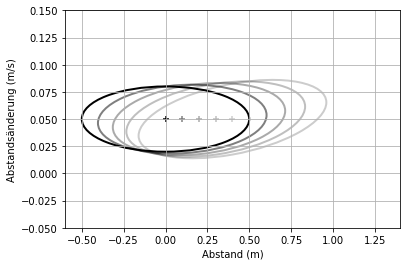

In [9]:
x = np.array([0., 0.05])
P = np.diag([0.25, 0.0009])
dt = 2
F = np.array([[1, dt],[0, 1]])
Q = Q_zero_mean(dim=2, dt=1., var=0.0001)
B = 0
u = 0
fig, ax = plt.subplots()
plot_covariance(x, P, alpha=1, std=[1], axis_equal=False, x_lim=1, y_lim=0.1)
for i in range(4):
    x,P = predict(x, P, F, Q, B, u)
    plot_covariance(x, P, alpha=1/(i+2), std=[1], axis_equal=False, x_lim=1, y_lim=0.1)
    
ax.set_xlabel('Abstand (m)')
ax.set_ylabel('Abstandsänderung (m/s)')

>**Letzlich ist dieses automatische Erscheinen der Korrelation die zentrale Eigenschaft, die diesen zweidimensionalen Kalman-Filter im Vergleich zum eindimensionalen auszeichnet.**  
Wie im Jupyter-Notebook zu den mehrdimensionalen Gaußverteilungen gezeigt, bewirkt diese Korrelation anschließend im Korrekturschritt die wesentlich bessere Schätzung der Zustandsgröße Abstand sowie überhaupt eine Schätzung der verdeckten Zustandsgröße Abstandsänderung.

## Der Korrekturschritt beim zweidimensionalen Kalman-Filter
Der Korrekturschritt ist beim Übergang zum zweidimensionalen Kalman-Filter auch nicht komplizierter als der Vorhersageschritt. Ähnlich wie die Steuermatrix bei der Vorhersage gibt es hier auch einen *neuen Parameter, die Beobachtungsmatrix $\mathbf H$.


### Die Beobachtungsmatrix
Bisher gab es zu jedem Zustandswert immer den entsprechenden Messwert. Daher konnte das Residuum $y$ einfach aus der Differenz zwischen dem Vorhersagewert und dem Messwert berechnet werden: $y = z - \bar x$.  
Aber schon beim Beispiel Roboterfahrzeug gibt es für die verdeckte Zustandsgröße Abstandsänderung keinen Messwert.
Außerdem gibt es oft Situationen, bei denen ein Messwert mehrdeutig ist - wie z.B. beim Phasenverfahren des Lidar-Sensors. In diesem Fall kann zwar über den Zustandswert eindeutig auf einen Messwert geschlossen werden. Umgekehrt ist das jedoch nicht möglich.  
Aus diesen Gründen ist es praktikabler, das Residuum nicht im "Zustandsraum" sondern im "Messwertraum" zu berechnen. Sprich man wandelt den Zustandsvektor der Vorhersage $\mathbf x$ zuerst in einen Messwertvektor um. Im Fall einer verdeckten Zustandsgröße fehlt dann im Messwertvektor die entsprechende Komponente, wie gleich gezeigt wird.
**Die Umwandlung vom Zustandsraum in den Messwertraum übernimmt die Beobachtungsmatrix $\mathbf H$.**

$$\mathbf y = \mathbf z - \mathbf{H \bar x}$$  

Entsprechend ändert sich die grafische Darstellung des eindimensionalen Kalmanfilters wie folgt:

<img src="grafikKalman_VorhersKorr_mehrDim.png" width="800">

Welche Elemente muss die Beobachtungsmatrix $\mathbf H$ für das Roboterfahrzeug besitzen?  
Bei der Abstandsänderung handelt es ich um eine verdeckte Zustandsgröße. Daher muss $\mathbf H$ eine solche Gestalt haben, dass  $\mathbf{H\bar x}$ einen eindimensionalen Messwertvektor $\mathbf z$ ergibt.  

$$\mathbf z = \begin{bmatrix}z_0\end{bmatrix}$$

Die Berechnungsformel für das Residuum, welches auch ein eindimensionaler Vektor ist, muss dann folgende Form annehmen:  

$$
\begin{aligned}
\textbf{y} &= \mathbf z - \mathbf{H\bar x}  \\
\begin{bmatrix}y \end{bmatrix} &= \begin{bmatrix}z_0\end{bmatrix} - \begin{bmatrix}?&?\end{bmatrix} \begin{bmatrix}x_0 \\  x_1\end{bmatrix}
\end{aligned}
$$

$\mathbf H$ muss also eine 1x2-Matrix sein. Und für das Residuum $\mathbf y$ muss gelten $\mathbf{y} = [z_0 - \bar x_0]$, denn es hängt nur vom Abstand $x_0$ ab.  

Folglich berechnet sich die Beobachtungsmatrix für das Roboterfahrzeug zu $\mathbf H=\begin{bmatrix}1&0\end{bmatrix}$.  
Nachfolgend wird diese Matrix im Code implementiert.

In [10]:
H = np.array([[1., 0.]])

### Der Messwertvektor und dessen Kovarianzmatrix
Der Messwertvektor beinhaltet die Sensormesswerte des Prozesses, d.h. hier die Messwerte des Abstandssensors des Roboterfahrzeugs. Da wegen der verdeckten Zustandsgröße "Abstandsänderung" nur ein Messwert im Vektor $\mathbf z$ vorliegt, gilt:

$$\mathbf z = \begin{bmatrix}z_0\end{bmatrix}$$

Bei zwei Messwerten würde beispielsweise gelten 

$$\mathbf z = \begin{bmatrix}z_0 \\ z_1\end{bmatrix}$$.

In der Kovarianzmatrix $\mathbf R$ von $\mathbf z$ sind die Messunsicherheiten enthalten. Sie ist eine quadratische Matrix der Form $m \times m$, wobei m die Anzahl der Sensoren bzw. unterschiedlichen Messgrößen ist. Bei mehreren Sensoren sind die Diagonalelemente meist bekannt, da es sich um die Varianzen = Messunsicherheiten der einzelnen Sensoren handelt. Leider sind die Messunsicherheiten verschiedener Sensoren oft korreliert und manchmal auch nicht wirklich gaußverteilt.  

Im hier betrachteten Beispiel des Roboterfahrzeugs lässt sich die Kovarianzmatrix $\mathbf R$ ganz einfach zu

$$R = \begin{bmatrix}\sigma^2_z\end{bmatrix}$$ 

bestimmen.

Für eine angenommene Standardabweichung $\sigma_{z_0} = 0,1 m$ und $\sigma_{z_0} = 0,4 m$ der beiden Sensoren würde sich die Matrix ergeben: 
$$R = \begin{bmatrix}0,01&0\\0&0,16\end{bmatrix}$$ 

Im Fall des Roboterfahrzeug mit nur einem Sensor mit $\sigma_{z_0} = 0,1 m$ berechnet sich die Kovarianzmatrix des Messwerts zu $R = \begin{bmatrix}0,01\end{bmatrix}$. 

In [11]:
sigma_z = 0.1
R = np.array([[sigma_z**2]])

Für das Roboterfahrzeug ist der zeidimensionale Kalman-Filter nun komplett initialisiert und alle Parameter sind berechnet. Der Vorhersagealgorithmus wurde oben schon in Python-Code implementiert. Gleiches muss nur noch mit dem Korrekturalgorithmus geschehen.
Dies sowie die Simulation des Roboterfahrzeugs sind die Inhalte des nächsten Jupyter-Notebooks. Darin wird dann auch der zweidimensionale Kalman-Filter an verschiedenen Simulationsdaten für das Roboterfahrzeug getestet.